In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import InputLayer
from keras.layers import LSTM,Reshape,Dropout
import keras
from keras import initializers, regularizers
from keras import layers
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

2025-06-19 17:13:46.686153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750353227.153291      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750353227.273646      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from keras import activations

In [30]:
data = pd.read_csv('/kaggle/input/nagpur-dataset-1/nagpur.csv')
df = pd.DataFrame(data)
for x in ['totalSnow_cm','uvIndex','uvIndex.1','sunrise','moonrise','sunset','moonset','sunHour','moon_illumination','cloudcover','visibility']:
    df.pop(x)

In [31]:
#df['date_time']
df['date_time'] = pd.to_datetime(df['date_time']) 
df

,date_time,maxtempC,mintempC,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,humidity,precipMM,pressure,tempC,winddirDegree,windspeedKmph
0,2009-01-01 00:00:00,30,14,6,17,17,17,14,48,0.0,1013,14,15,6
1,2009-01-01 01:00:00,30,14,6,17,17,17,16,48,0.0,1014,14,21,8
2,2009-01-01 02:00:00,30,14,5,16,16,16,19,48,0.0,1014,14,27,9
3,2009-01-01 03:00:00,30,14,5,15,15,15,21,49,0.0,1015,14,32,10
4,2009-01-01 04:00:00,30,14,5,17,17,17,18,47,0.0,1015,15,34,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96427,2020-01-01 19:00:00,24,14,16,20,21,20,16,76,0.1,1016,20,105,9
96428,2020-01-01 20:00:00,24,14,16,19,20,19,19,79,0.3,1017,19,103,10
96429,2020-01-01 21:00:00,24,14,15,18,18,18,21,82,0.4,1018,18,101,12
96430,2020-01-01 22:00:00,24,14,15,18,18,18,21,83,0.2,1018,18,98,12


In [32]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)#set datetime as index 

In [33]:
col_order = ['tempC', 'pressure', 'humidity', 'maxtempC', 'mintempC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
        'winddirDegree', 'windspeedKmph','precipMM','DewPointC']
df = df[col_order]

In [34]:

# Replace some faulty data with the average from 2 days
from datetime import datetime, timedelta
base_date = datetime(2019, 9, 16)

# Loop through each hour of the day
for h in range(6,28):
    time_stamp = base_date + timedelta(hours=h)  # this is a datetime object
    
    prev_date = time_stamp - timedelta(days=2)
    prev_date = prev_date + timedelta(hours=h)
    pp_date = time_stamp - timedelta(days=3)
    pp_date = pp_date + timedelta(hours=h)
    row = (df.loc[prev_date] + df.loc[pp_date]) // 2
   
    df.loc[time_stamp] = row



In [35]:
df = df.reset_index()
df = df.rename(columns={'index': 'date_time'})

In [36]:
import pandas as pd

# Example: ensure the date column is in datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

 #Extract the month
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day

df['season'] = df['month'].apply(
    lambda month: 'Summer' if month in [3, 4, 5, 6]
    else 'Monsoon' if month in [7,8, 9,10]
    else 'Winter'
)

# Optional: separate dataframes
summer_df = df[df['season'] == 'Summer']
monsoon_df = df[df['season'] == 'Monsoon']
winter_df = df[df['season'] == 'Winter']


In [37]:
summer_df = summer_df.set_index('date_time')
monsoon_df = monsoon_df.set_index('date_time')
winter_df = winter_df.set_index('date_time')

In [38]:
summer_df.pop('season')
monsoon_df.pop('season')
winter_df.pop('season')



date_time
2009-01-01 00:00:00    Winter
2009-01-01 01:00:00    Winter
2009-01-01 02:00:00    Winter
2009-01-01 03:00:00    Winter
2009-01-01 04:00:00    Winter
                        ...  
2020-01-01 19:00:00    Winter
2020-01-01 20:00:00    Winter
2020-01-01 21:00:00    Winter
2020-01-01 22:00:00    Winter
2020-01-01 23:00:00    Winter
Name: season, Length: 31752, dtype: object

In [202]:
# Extract month and year from the index
#summer_df['year'] = summer_df.index.year


#month_order = [3, 4, 5, 6]
#summer_df['month_order'] = summer_df['month'].apply(lambda m: month_order.index(m))

 #Sort by custom month order, then by year, then by full date
#df_sorted = summer_df.sort_values(by=['month_order', 'year', summer_df.index.name])

# Drop helper columns if needed
#df_sorted = df_sorted.drop(columns=['year', 'month_order'])
#summer_df = df_sorted



In [203]:
# Extract month and year from the index
#winter_df['year'] = winter_df.index.year


#winter_order = [10,11,12,1,2]
#winter_df['month_order'] = winter_df['month'].apply(lambda m: winter_order.index(m))

#Sort by custom month order, then by year, then by full date
#df_sorted = winter_df.sort_values(by=['month_order', 'year', winter_df.index.name])

#Drop helper columns if needed
#df_sorted = df_sorted.drop(columns=['year', 'month_order'])
#winter_df = df_sorted


In [204]:
# Extract month and year from the index
#monsoon_df['year'] = monsoon_df.index.year


#monsoon_order = [7,8,9]
#monsoon_df['month_order'] = monsoon_df['month'].apply(lambda m: monsoon_order.index(m))

#Sort by custom month order, then by year, then by full date
#df_sorted = monsoon_df.sort_values(by=['month_order', 'year', monsoon_df.index.name])

#Drop helper columns if needed
#df_sorted = df_sorted.drop(columns=['year', 'month_order'])
#monsoon_df = df_sorted

In [39]:
nsteps_in = 3
nsteps_out = 1
features_out = 1
features_in = 15

In [40]:
n = len(summer_df)
train_end = int(0.8*n)
train_end = train_end - (train_end%24)

summer_train = summer_df[:train_end]
summer_test = summer_df[train_end:]

from sklearn.preprocessing import MinMaxScaler
summer_train_scaled = summer_train.copy()
summer_train_numeric = summer_train.select_dtypes(include=['number'])
summer_train_scaler = MinMaxScaler(feature_range=(0, 1))
summer_train_scaled = pd.DataFrame(
    summer_train_scaler.fit_transform(summer_train_numeric),
    columns=summer_train_numeric.columns,
    index=summer_train.index
)

from sklearn.preprocessing import MinMaxScaler
summer_test_scaled = summer_test.copy()
summer_test_numeric = summer_test.select_dtypes(include=['number'])
summer_test_scaler = MinMaxScaler(feature_range=(0, 1))
summer_test_scaled = pd.DataFrame(
    summer_test_scaler.fit_transform(summer_test_numeric),
    columns=summer_test_numeric.columns,
    index=summer_test.index
)

In [41]:
n = len(winter_df)
train_end = int(0.8*n)
train_end = train_end - (train_end%24)
winter_train = winter_df[:train_end]
winter_test = winter_df[train_end:]

from sklearn.preprocessing import MinMaxScaler
winter_train_scaled = winter_train.copy()
winter_train_numeric = winter_train.select_dtypes(include=['number'])
winter_train_scaler = MinMaxScaler(feature_range=(0, 1))
winter_train_scaled = pd.DataFrame(
    winter_train_scaler.fit_transform(winter_train_numeric),
    columns=winter_train_numeric.columns,
    index=winter_train.index
)

winter_test_scaled = winter_test.copy()
winter_test_numeric = winter_test.select_dtypes(include=['number'])
winter_test_scaler = MinMaxScaler(feature_range=(0, 1))
winter_test_scaled = pd.DataFrame(
    winter_test_scaler.fit_transform(winter_test_numeric),
    columns=winter_test_numeric.columns,
    index=winter_test.index
)


In [42]:
n = len(monsoon_df)
train_end = int(0.8*n)
train_end = train_end - (train_end%24)
monsoon_train = monsoon_df[:train_end]
monsoon_test = monsoon_df[train_end:]

from sklearn.preprocessing import MinMaxScaler
monsoon_train_scaled = monsoon_train.copy()
monsoon_train_numeric =  monsoon_train.select_dtypes(include=['number'])
monsoon_train_scaler = MinMaxScaler(feature_range=(0, 1))
monsoon_train_scaled = pd.DataFrame(
    monsoon_train_scaler.fit_transform(monsoon_train_numeric),
    columns=monsoon_train_numeric.columns,
    index=monsoon_train.index
)

monsoon_test_scaled = monsoon_test.copy()
monsoon_test_numeric =  monsoon_test.select_dtypes(include=['number'])
monsoon_test_scaler = MinMaxScaler(feature_range=(0, 1))
monsoon_test_scaled = pd.DataFrame(
    monsoon_test_scaler.fit_transform(monsoon_test_numeric),
    columns=monsoon_test_numeric.columns,
    index=monsoon_test.index
)

In [43]:
summer_train_datetime = summer_train_scaled.index
summer_train_datetime
summer_test_datetime = summer_test_scaled.index
summer_test_datetime
winter_train_datetime = winter_train_scaled.index
winter_train_datetime
winter_test_datetime = winter_test_scaled.index
winter_test_datetime
monsoon_train_datetime = monsoon_train_scaled.index
monsoon_train_datetime
monsoon_test_datetime = monsoon_test_scaled.index
monsoon_test_datetime

DatetimeIndex(['2017-10-07 00:00:00', '2017-10-07 01:00:00',
               '2017-10-07 02:00:00', '2017-10-07 03:00:00',
               '2017-10-07 04:00:00', '2017-10-07 05:00:00',
               '2017-10-07 06:00:00', '2017-10-07 07:00:00',
               '2017-10-07 08:00:00', '2017-10-07 09:00:00',
               ...
               '2019-10-31 14:00:00', '2019-10-31 15:00:00',
               '2019-10-31 16:00:00', '2019-10-31 17:00:00',
               '2019-10-31 18:00:00', '2019-10-31 19:00:00',
               '2019-10-31 20:00:00', '2019-10-31 21:00:00',
               '2019-10-31 22:00:00', '2019-10-31 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=6504, freq=None)

In [44]:
def split_sequence(sequence,out_seq,n_steps_in, n_steps_out, stride=1):
    X, y = list(), list()
    sequence = sequence
    out_seq = out_seq
    
    # Use stride (x) to control how much the window shifts
    for i in range(0, len(sequence), stride): # 0 to 1073
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        seq_x, seq_y = sequence[i:end_ix], out_seq[end_ix:out_end_ix]
        seq_y = np.array(seq_y)
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [45]:
block_size = 24  # 24-hour block
summer_total_rows = len(summer_train_scaled)
summer_num_blocks = summer_total_rows // block_size

summer_blocks_X = []
dated_summer_blocks_X = []
for i in range(0, summer_num_blocks * block_size, block_size):
    summer_block = summer_train_scaled.iloc[i:i + block_size].values 
    summer_transposed = summer_block  
    summer_blocks_X.append(summer_transposed)
    summer_train_datetime = pd.Series(summer_train.index)
    dated_summer_block = summer_train_datetime.iloc[i:i + block_size]
    dated_summer_blocks_X.append(dated_summer_block)
    

summer_blocks_Y = []
dated_summer_blocks_Y = []
block_size = 24  # 24-hour block
summer_total_rows = len(summer_train_scaled)
summer_num_blocks = summer_total_rows // block_size
for i in range(0, summer_num_blocks * block_size, block_size):
    summer_block = summer_train_scaled.iloc[i:i + block_size, 0].values # index 0 indicates it select 'tempc' col only in dataframe
    summer_blocks_Y.append(summer_block)
    summer_train_datetime = pd.Series(summer_train.index)
    dated_summer_block = summer_train_datetime.iloc[i:i + block_size]
    dated_summer_blocks_Y.append(dated_summer_block)
    



In [46]:
len(summer_blocks_X)

1073

In [47]:
block_size = 24  # 24-hour block
summer_total_rows = len(summer_test_scaled)
summer_num_blocks = summer_total_rows // block_size

summer_testBlocks_X = []

for i in range(0, summer_num_blocks * block_size, block_size):
    summer_block = summer_test_scaled.iloc[i:i + block_size].values       
    summer_transposed = summer_block                      
    summer_testBlocks_X.append(summer_transposed)

summer_testBlocks_Y = []
dated_summer_testBlocks_Y = []
block_size = 24  # 24-hour block
summer_total_rows = len(summer_train_scaled)
summer_num_blocks = summer_total_rows // block_size
for i in range(0, summer_num_blocks * block_size, block_size):
    summer_block = summer_test_scaled.iloc[i:i + block_size, 0].values # index 0 indicates it select 'tempc' col only in dataframe
    summer_testBlocks_Y.append(summer_block)
    summer_test_datetime = pd.Series(summer_test.index)
    dated_summer_block = summer_test_datetime.iloc[i:i + block_size]
    dated_summer_testBlocks_Y.append(dated_summer_block)

In [48]:
block_size = 24  # 24-hour block
winter_total_rows = len(winter_train_scaled)
winter_num_blocks = winter_total_rows // block_size

winter_blocks_X = []
for i in range(0, winter_num_blocks * block_size, block_size):
    winter_block = winter_train_scaled.iloc[i:i + block_size].values       
    winter_transposed = winter_block                     
    winter_blocks_X.append(winter_transposed)

winter_blocks_Y = []
dated_winter_blocks_Y = []
for i in range(0, winter_num_blocks * block_size, block_size):
    winter_block = winter_train_scaled.iloc[i:i + block_size, 0].values       
    winter_blocks_Y.append(winter_block)
    winter_train_datetime = pd.Series(winter_train.index)
    dated_winter_block = winter_train_datetime.iloc[i:i + block_size]
    dated_winter_blocks_Y.append(dated_winter_block)


In [49]:
block_size = 24  # 24-hour block
winter_total_rows = len(winter_test_scaled)
winter_num_blocks = winter_total_rows // block_size

winter_testBlocks_X = []

for i in range(0, winter_num_blocks * block_size, block_size):
    winter_block = winter_test_scaled.iloc[i:i + block_size].values       
    winter_transposed = winter_block                   
    winter_testBlocks_X.append(winter_transposed)

winter_testBlocks_Y = []
dated_winter_testBlocks_Y = []
block_size = 24  # 24-hour block
winter_total_rows = len(winter_train_scaled)
winter_num_blocks = winter_total_rows // block_size
for i in range(0, winter_num_blocks * block_size, block_size):
    winter_block = winter_test_scaled.iloc[i:i + block_size, 0].values       
    winter_testBlocks_Y.append(winter_block)
    winter_test_datetime = pd.Series(winter_test.index)
    dated_winter_block = winter_test_datetime.iloc[i:i + block_size]
    dated_winter_testBlocks_Y.append(dated_winter_block)

In [50]:
block_size = 24  # 24-hour block
monsoon_total_rows = len(monsoon_train_scaled)
monsoon_num_blocks = monsoon_total_rows // block_size

monsoon_blocks_X = []
for i in range(0, monsoon_num_blocks * block_size, block_size):
    monsoon_block = monsoon_train_scaled.iloc[i:i + block_size].values       
    monsoon_transposed = monsoon_block                     
    monsoon_blocks_X.append(monsoon_transposed)

monsoon_blocks_Y = []
dated_monsoon_blocks_Y = []
for i in range(0, monsoon_num_blocks * block_size, block_size):
    monsoon_block = monsoon_train_scaled.iloc[i:i + block_size, 0].values       
    monsoon_blocks_Y.append(monsoon_block)
    monsoon_train_datetime = pd.Series(monsoon_train.index)
    dated_monsoon_block = monsoon_train_datetime.iloc[i:i + block_size]
    dated_monsoon_blocks_Y.append(dated_monsoon_block)

In [51]:
block_size = 24  # 24-hour block
monsoon_total_rows = len(monsoon_test_scaled)
monsoon_num_blocks = monsoon_total_rows // block_size

monsoon_testBlocks_X = []

for i in range(0, monsoon_num_blocks * block_size, block_size):
    monsoon_block = monsoon_test_scaled.iloc[i:i + block_size].values       
    monsoon_transposed = monsoon_block                     
    monsoon_testBlocks_X.append(monsoon_transposed)

monsoon_testBlocks_Y = []
dated_monsoon_testBlocks_Y = []
block_size = 24  # 24-hour block
monsoon_total_rows = len(monsoon_test_scaled)
monsoon_num_blocks = monsoon_total_rows // block_size
for i in range(0, monsoon_num_blocks * block_size, block_size):
    monsoon_block = monsoon_test_scaled.iloc[i:i + block_size, 0].values       
    monsoon_testBlocks_Y.append(monsoon_block)
    monsoon_test_datetime = pd.Series(monsoon_test.index)
    dated_monsoon_block = monsoon_test_datetime.iloc[i:i + block_size]
    dated_monsoon_testBlocks_Y.append(dated_monsoon_block)

In [52]:
summer_train_X, summer_train_Y = split_sequence(summer_blocks_X, summer_blocks_Y, nsteps_in,nsteps_out,1)
summer_test_X, summer_test_Y = split_sequence(summer_testBlocks_X, summer_testBlocks_Y, nsteps_in, nsteps_out,1)
_, dated_summer_train_Y = split_sequence(summer_blocks_X, dated_summer_blocks_Y, nsteps_in,nsteps_out,1)
_, dated_summer_test_Y = split_sequence(summer_testBlocks_X, dated_summer_testBlocks_Y, nsteps_in, nsteps_out,1)

In [53]:
summer_train_X.shape[0]

1070

In [54]:
summer_test_X.shape

(266, 3, 24, 15)

In [55]:
summer_test_X.shape[3]

15

In [56]:
winter_train_X, winter_train_Y = split_sequence(winter_blocks_X, winter_blocks_Y, nsteps_in,nsteps_out,1)
winter_test_X, winter_test_Y = split_sequence(winter_testBlocks_X, winter_testBlocks_Y, nsteps_in, nsteps_out,1)
_, dated_winter_train_Y = split_sequence(winter_blocks_X, dated_winter_blocks_Y, nsteps_in,nsteps_out,1)
_, dated_winter_test_Y = split_sequence(winter_testBlocks_X, dated_winter_testBlocks_Y, nsteps_in, nsteps_out,1)

In [57]:
monsoon_train_X, monsoon_train_Y = split_sequence(monsoon_blocks_X, monsoon_blocks_Y, nsteps_in,nsteps_out,1)
monsoon_test_X, monsoon_test_Y = split_sequence(monsoon_testBlocks_X, monsoon_testBlocks_Y, nsteps_in, nsteps_out,1)
_, dated_monsoon_train_Y = split_sequence(monsoon_blocks_X, dated_monsoon_blocks_Y, nsteps_in,nsteps_out,1)
_, dated_monsoon_test_Y = split_sequence(monsoon_testBlocks_X, dated_monsoon_testBlocks_Y, nsteps_in, nsteps_out,1)

In [58]:
summer_train_Y  = summer_train_Y.reshape(summer_train_Y.shape[0], nsteps_out*24,features_out)
summer_test_Y = summer_test_Y.reshape(summer_test_Y.shape[0], nsteps_out*24, features_out)
dated_summer_train_Y  = dated_summer_train_Y.reshape(dated_summer_train_Y.shape[0], nsteps_out*24,1)
dated_summer_test_Y  = dated_summer_test_Y.reshape(dated_summer_test_Y.shape[0], nsteps_out*24,1)

In [59]:

winter_train_Y  = winter_train_Y.reshape(winter_train_Y.shape[0], nsteps_out*24,features_out)
winter_test_Y = winter_test_Y.reshape(winter_test_Y.shape[0], nsteps_out*24, features_out)
dated_winter_train_Y  = dated_winter_train_Y.reshape(dated_winter_train_Y.shape[0], nsteps_out*24,1)
dated_winter_test_Y  = dated_winter_test_Y.reshape(dated_winter_test_Y.shape[0], nsteps_out*24,1)


In [60]:


monsoon_train_Y  = monsoon_train_Y.reshape(monsoon_train_Y.shape[0], nsteps_out*24,features_out)
monsoon_test_Y = monsoon_test_Y.reshape(monsoon_test_Y.shape[0], nsteps_out*24, features_out)

dated_monsoon_train_Y  = dated_monsoon_train_Y.reshape(dated_monsoon_train_Y.shape[0], nsteps_out*24,1)
dated_monsoon_test_Y  = dated_monsoon_test_Y.reshape(dated_monsoon_test_Y.shape[0], nsteps_out*24,1)

In [61]:
summer_train_Y.shape

(1070, 24, 1)

In [62]:
summer_train_X = summer_train_X.reshape(summer_train_X.shape[0], nsteps_in*24, summer_train_X.shape[3])
winter_train_X = winter_train_X.reshape(winter_train_X.shape[0], nsteps_in*24, winter_train_X.shape[3])
monsoon_train_X = monsoon_train_X.reshape(monsoon_train_X.shape[0], nsteps_in*24, monsoon_train_X.shape[3])

In [63]:
summer_test_X = summer_test_X.reshape(summer_test_X.shape[0], nsteps_in*24, summer_test_X.shape[3])
winter_test_X = winter_test_X.reshape(winter_test_X.shape[0], nsteps_in*24, winter_test_X.shape[3])
monsoon_test_X = monsoon_test_X.reshape(monsoon_test_X.shape[0], nsteps_in*24, monsoon_test_X.shape[3])

In [64]:
summer_train_X.shape

(1070, 72, 15)

In [65]:
len(dated_monsoon_test_Y[0][0])

1

In [66]:
date_list_summer_train_Y = []

for i in range(len(dated_summer_train_Y)):
    for j in range(len(dated_summer_train_Y[i])):
        date_list_summer_train_Y.append(dated_summer_train_Y[i][j][0])

date_list_summer_test_Y = []

for i in range(len(dated_summer_test_Y)):
    for j in range(len(dated_summer_test_Y[i])):
        date_list_summer_test_Y.append(dated_summer_test_Y[i][j][0])



In [67]:
date_list_monsoon_train_Y = []

for i in range(len(dated_monsoon_train_Y)):
    for j in range(len(dated_monsoon_train_Y[i])):
        date_list_monsoon_train_Y.append(dated_monsoon_train_Y[i][j][0])

date_list_monsoon_test_Y = []

for i in range(len(dated_monsoon_test_Y)):
    for j in range(len(dated_monsoon_test_Y[i])):
        date_list_monsoon_test_Y.append(dated_monsoon_test_Y[i][j][0])

In [68]:
len(date_list_monsoon_test_Y)

6432

In [69]:
date_list_winter_train_Y = [] 

for i in range(len(dated_winter_train_Y)):
    for j in range(len(dated_winter_train_Y[i])):
        date_list_winter_train_Y.append(dated_winter_train_Y[i][j][0])

date_list_winter_test_Y = []

for i in range(len(dated_winter_test_Y)):
    for j in range(len(dated_winter_test_Y[i])):
        date_list_winter_test_Y.append(dated_winter_test_Y[i][j][0])


In [70]:
date_list_summer_train_Y

[numpy.datetime64('2009-03-04T00:00:00.000000000'),
 numpy.datetime64('2009-03-04T01:00:00.000000000'),
 numpy.datetime64('2009-03-04T02:00:00.000000000'),
 numpy.datetime64('2009-03-04T03:00:00.000000000'),
 numpy.datetime64('2009-03-04T04:00:00.000000000'),
 numpy.datetime64('2009-03-04T05:00:00.000000000'),
 numpy.datetime64('2009-03-04T06:00:00.000000000'),
 numpy.datetime64('2009-03-04T07:00:00.000000000'),
 numpy.datetime64('2009-03-04T08:00:00.000000000'),
 numpy.datetime64('2009-03-04T09:00:00.000000000'),
 numpy.datetime64('2009-03-04T10:00:00.000000000'),
 numpy.datetime64('2009-03-04T11:00:00.000000000'),
 numpy.datetime64('2009-03-04T12:00:00.000000000'),
 numpy.datetime64('2009-03-04T13:00:00.000000000'),
 numpy.datetime64('2009-03-04T14:00:00.000000000'),
 numpy.datetime64('2009-03-04T15:00:00.000000000'),
 numpy.datetime64('2009-03-04T16:00:00.000000000'),
 numpy.datetime64('2009-03-04T17:00:00.000000000'),
 numpy.datetime64('2009-03-04T18:00:00.000000000'),
 numpy.datet

In [40]:
 #model.add(Conv2D(filters=64,kernel_size=(3,1),padding="same",activation='relu'))
    #model.add(Conv2D(filters=64, kernel_size=(1,3),padding='same',activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
    #model.add(Conv2D(filters=32,kernel_size=(3,1), padding = "same",activation='relu',activity_regularizer=activity))
    #model.add(Conv2D(filters=32, kernel_size=(1,3),padding="same",activation='relu',activity_regularizer=activity))
    #MaxPooling2D(pool_size=(3, 3),padding="same")

In [41]:
'''saved_model_weights = []

class RMSECheckpoint(keras.callbacks.Callback):
    """Custom callback to save model weights when RMSE is at its lowest"""
    
    def __init__(self, weights_list=None, save_best_only=True, min_improvement=0.001):
        super().__init__()
        self.weights_list = weights_list if weights_list is not None else saved_model_weights
        self.save_best_only = save_best_only
        self.min_improvement = min_improvement
        self.best_train_rmse = float('inf')
        self.best_val_rmse = float('inf')
        self.best_combined_rmse = float('inf')
    
    def on_epoch_end(self, epoch, logs=None):
        """Check RMSE at end of each epoch and save weights if improved"""
        if logs is None:
            return
        
        # Calculate RMSE from MSE loss
        train_loss = logs.get('loss', float('inf'))
        val_loss = logs.get('val_loss', float('inf'))
        
        train_rmse = math.sqrt(train_loss) if train_loss > 0 else float('inf')
        val_rmse = math.sqrt(val_loss) if val_loss > 0 else float('inf')
        combined_rmse = (train_rmse + val_rmse) / 2
        
        # Check if we should save (either best overall or significant improvement)
        should_save = False
        save_reason = ""
        
        if self.save_best_only:
            # Save only if combined RMSE is the best we've seen
            if combined_rmse < self.best_combined_rmse - self.min_improvement:
                should_save = True
                save_reason = f"Best combined RMSE: {combined_rmse:.6f}"
        else:
            # Save if either train or val RMSE improved significantly
            if (train_rmse < self.best_train_rmse - self.min_improvement or 
                val_rmse < self.best_val_rmse - self.min_improvement):
                should_save = True
                save_reason = f"RMSE improved - Train: {train_rmse:.6f}, Val: {val_rmse:.6f}"
        
        if should_save:
            # Update best scores
            self.best_train_rmse = min(self.best_train_rmse, train_rmse)
            self.best_val_rmse = min(self.best_val_rmse, val_rmse)
            self.best_combined_rmse = min(self.best_combined_rmse, combined_rmse)
            
            # Create a deep copy of model weights
            weights_copy = [layer.get_weights() for layer in self.model.layers if layer.get_weights()]
            
            # Get additional metrics
            train_mae = logs.get('mae', 0)
            val_mae = logs.get('val_mae', 0)
            
            # Store weights with metadata
            weight_info = {
                'epoch': epoch + 1,
                'weights': weights_copy,
                'train_rmse': float(train_rmse),
                'val_rmse': float(val_rmse),
                'combined_rmse': float(combined_rmse),
                'train_loss': float(train_loss),
                'val_loss': float(val_loss),
                'train_mae': float(train_mae),
                'val_mae': float(val_mae),
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'save_reason': save_reason
            }
            
            self.weights_list.append(weight_info)
            
            print(f"\n✅ WEIGHTS SAVED!")
            print(f"📊 Epoch: {epoch + 1}")
            print(f"📉 Train RMSE: {train_rmse:.6f}")
            print(f"📉 Val RMSE: {val_rmse:.6f}")
            print(f"📈 Combined RMSE: {combined_rmse:.6f}")
            print(f"🎯 Reason: {save_reason}")
            print(f"💾 Total saved models: {len(self.weights_list)}")
            print("-" * 60)
        else:
            # Show progress without saving
            improvement_train = self.best_train_rmse - train_rmse
            improvement_val = self.best_val_rmse - val_rmse
            print(f"Epoch {epoch + 1}: Train RMSE: {train_rmse:.6f} (Δ{improvement_train:+.6f}), "
                  f"Val RMSE: {val_rmse:.6f} (Δ{improvement_val:+.6f}) - Not saved")

    
'''

In [124]:
'''def summer_build(X_train, Y_train, save_weights=True, 
                save_best_only=True, min_improvement=0.0005):
    global saved_model_weights
    saved_model_weights.clear()
    model = Sequential()
    activity = regularizers.L2(0.00001)
    # Convolutional layers
  #  model.add(input_layer)
    model.add(Conv2D(filters=8, kernel_size=(1,15), strides=(1, 1), padding="same", 
                     activation='relu',input_shape=(72,15,1)))
    #model.add(MaxPooling2D(pool_size=(2, 1), padding="same"))
    #input_shape=(72,15,1)
    model.add(Conv2D(filters=8, kernel_size=(3,1), strides=(1, 1), padding="same", 
                     activation='relu', activity_regularizer=activity))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=16, kernel_size=(3,1), strides=(1, 1), padding="same", 
                     activation='relu', activity_regularizer=activity))
    model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding="same", 
                     activation='relu', activity_regularizer=activity))
    model.add(MaxPooling2D(pool_size=( 3,3), padding="same"))
    #model.add(Conv2D(filters=32, kernel_size=(2,2), padding="same", 
                     #activation='relu', activity_regularizer=activity))
   # model.add(Conv2D(filters=64, kernel_size=(2,2), padding='same', 
                    # activation='relu', activity_regularizer=activity))
   # model.add(MaxPooling2D(pool_size=(3,3), padding="same"))
   # model.add(Dropout(0.2))

    initializer = initializers.GlorotUniform()
    
    # Reshape for LSTM
    conv_output_shape = model.output_shape
    print(f"Conv output shape: {conv_output_shape}")
    #model.add(Reshape((-1, conv_output_shape[3])))
    model.add(Flatten())
    model.add(Dense(1152, activation=activations.sigmoid, activity_regularizer=activity))
    model.add(Dense(256, activation=activations.leaky_relu, activity_regularizer=activity))
    model.add(Reshape((4,64)))
    model.add(LSTM(72,return_sequences=True,activity_regularizer=activity))
    model.add(LSTM(72,return_sequences=False,activity_regularizer=activity))
    #model.add(Dropout(0.2))

    #model.add(Dense(256, activation=activations.leaky_relu, activity_regularizer=activity))
    model.add(Dense((nsteps_out*features_out*24),  activation= activations.linear,activity_regularizer=activity, kernel_initializer=initializer))
    model.add(Reshape((nsteps_out*24, features_out)))
    
    # Compile model
    model.compile(loss='mse', 
                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=['mae','accuracy'])
    
    # Prepare callbacks
    callbacks = []
    if save_weights:
        rmse_callback = RMSECheckpoint(save_best_only=save_best_only, 
                                      min_improvement=min_improvement)
        callbacks.append(rmse_callback)
    
    # Train model
    print(f"🚀 Starting training with RMSE-based weight saving")
    print(f"💾 Weight saving: {'Enabled' if save_weights else 'Disabled'}")
    print(f"🎯 Save strategy: {'Best only' if save_best_only else 'All improvements'}")
    print(f"📊 Min improvement: {min_improvement}")
    print("-" * 60)
    
    history = model.fit(X_train, Y_train, 
                       validation_split=0.10, 
                       epochs=800, 
                       batch_size=128,
                       callbacks=callbacks,
                       verbose=1)
    
    print(f"\n🎉 Training completed!")
    print(f"💾 Total models saved: {len(saved_model_weights)}")
    
    return model, history, saved_model_weights if save_weights else []'''

In [75]:
from tensorflow.keras.models import load_model
summer_path = f"/kaggle/input/summer_model_load/tensorflow2/default/1"
summer_model = load_model(summer_path)

I0000 00:00:1750354095.112216      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750354095.112949      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [76]:
monsoon_path = f"/kaggle/input/monsoon_model_load/tensorflow2/default/1"
monsoon_model = load_model(monsoon_path)

In [77]:
winter_path = f"/kaggle/input/winter_model_load/tensorflow2/default/1"
winter_model = load_model(winter_path)

In [125]:
'''def restore_best_weights(model, weights_list=None, metric='combined_rmse'):
    """
    Restore the best performing weights from saved list based on RMSE
    
    Args:
        model: Model to restore weights to
        weights_list: List of saved weights (uses global list if None)
        metric: Metric to use for selection ('combined_rmse', 'train_rmse', 'val_rmse')
    
    Returns:
        bool: True if weights were restored, False otherwise
    """
    if weights_list is None:
        weights_list = saved_model_weights
    
    if not weights_list:
        print("❌ No saved weights found!")
        return False
    
    # Find best weights based on specified metric (lowest RMSE)
    best_weights = min(weights_list, key=lambda x: x[metric])
    
    print(f"🔄 Restoring best weights (lowest {metric}):")
    print(f"📊 Epoch: {best_weights['epoch']}")
    print(f"📉 Train RMSE: {best_weights['train_rmse']:.6f}")
    print(f"📉 Val RMSE: {best_weights['val_rmse']:.6f}")
    print(f"📈 Combined RMSE: {best_weights['combined_rmse']:.6f}")
    print(f"🎯 Reason saved: {best_weights['save_reason']}")
    
    # Restore weights layer by layer
    layer_idx = 0
    for layer in model.layers:
        if layer.get_weights():  # Only layers with weights
            if layer_idx < len(best_weights['weights']):
                layer.set_weights(best_weights['weights'][layer_idx])
                layer_idx += 1
    
    print("✅ Weights restored successfully!")
    return True'''

In [78]:
import copy
from datetime import datetime
import math

In [127]:
summer_model,summer_history, model_weights = summer_build(summer_train_X, summer_train_Y)

Conv output shape: (None, 12, 3, 16)
🚀 Starting training with RMSE-based weight saving
💾 Weight saving: Enabled
🎯 Save strategy: Best only
📊 Min improvement: 0.0005
------------------------------------------------------------
Epoch 1/800


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1750093673.598565      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 2.6150e-04 - loss: 0.7162 - mae: 0.4813
✅ WEIGHTS SAVED!
📊 Epoch: 1
📉 Train RMSE: 0.782404
📉 Val RMSE: 0.657153
📈 Combined RMSE: 0.719779
🎯 Reason: Best combined RMSE: 0.719779
💾 Total saved models: 1
------------------------------------------------------------
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 3.1176e-04 - loss: 0.6768 - mae: 0.4483 - val_accuracy: 0.0000e+00 - val_loss: 0.4319 - val_mae: 0.1943
Epoch 2/800
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 5.0130e-04 - loss: 0.4754 - mae: 0.1863
✅ WEIGHTS SAVED!
📊 Epoch: 2
📉 Train RMSE: 0.645067
📉 Val RMSE: 0.535352
📈 Combined RMSE: 0.590209
🎯 Reason: Best combined RMSE: 0.590209
💾 Total saved models: 2
------------------------------------------------------------
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 4.7541e-04 - loss: 0.4539 - mae: 0.1804 - val_accuracy: 0.0000e+00 - val_loss: 0.2866 - val_mae: 0.1353
Epoch 3/800
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc

KeyboardInterrupt: 

In [79]:
summer_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 72, 15, 8)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 72, 15, 8)           │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 36, 8, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 36, 8, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 36, 8, 16)           │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 36, 8, 16)           │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 3, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1152)                │         664,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 4, 72)               │          39,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 72)                  │          41,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 24)                  │           1,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 24, 1)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,137,666 (11.97 MB)

 Trainable params: 1,045,888 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,091,778 (7.98 MB)

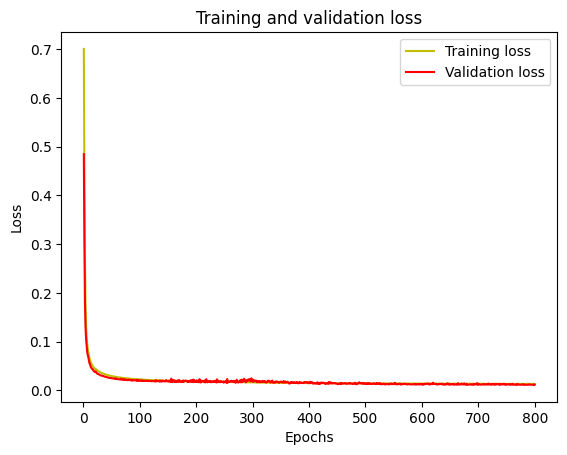

In [105]:
loss = summer_history.history['loss']
val_loss = summer_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [106]:
restore_best_weights(summer_model)
summer_model.save('summer_model_t.keras')

🔄 Restoring best weights (lowest combined_rmse):
📊 Epoch: 797
📉 Train RMSE: 0.113839
📉 Val RMSE: 0.104735
📈 Combined RMSE: 0.109287
🎯 Reason saved: Best combined RMSE: 0.109287
✅ Weights restored successfully!


In [142]:
'''def winter_build(X_train, Y_train, save_weights=True, 
                save_best_only=True, min_improvement=0.0005):
    global saved_model_weights
    saved_model_weights.clear()
    model = Sequential()
    activity = regularizers.L2(0.00001)
    # Convolutional layers
    model.add(Conv2D(filters=8, kernel_size=(1,15), strides=(1, 1), padding="same", 
                     activation='relu',input_shape=(72,15,1)))
    #model.add(MaxPooling2D(pool_size=(2, 1), padding="same"))
    #input_shape=(72,15,1)
    model.add(Conv2D(filters=8, kernel_size=(3,1), strides=(1, 1), padding="same", 
                     activation='relu', activity_regularizer=activity))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Conv2D(filters=16, kernel_size=(3,1), strides=(1, 1), padding="same", 
                     activation='relu', activity_regularizer=activity))
    model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding="same", 
                     activation='relu', activity_regularizer=activity))
    model.add(MaxPooling2D(pool_size=( 3,3), padding="same"))
   

    initializer = initializers.GlorotUniform()
    
    # Reshape for LSTM
    conv_output_shape = model.output_shape
    print(f"Conv output shape: {conv_output_shape}")
    #model.add(Reshape((-1, conv_output_shape[3])))
    model.add(Flatten())
    model.add(Dense(1024, activation=activations.sigmoid, activity_regularizer=activity))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation=activations.leaky_relu, activity_regularizer=activity))
    model.add(Reshape((4,64)))
    model.add(LSTM(72,return_sequences=True,activity_regularizer=activity))
    model.add(LSTM(72,return_sequences=False,activity_regularizer=activity))
    model.add(Dense((nsteps_out*features_out*24),  activation= activations.linear,activity_regularizer=activity, kernel_initializer=initializer))
    model.add(Reshape((nsteps_out*24, features_out)))    # Compile model
    model.compile(loss='mse', 
                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=['mae','accuracy'])
    
    # Prepare callbacks
    callbacks = []
    if save_weights:
        rmse_callback = RMSECheckpoint(save_best_only=save_best_only, 
                                      min_improvement=min_improvement)
        callbacks.append(rmse_callback)
    
    # Train model
    print(f"🚀 Starting training with RMSE-based weight saving")
    print(f"💾 Weight saving: {'Enabled' if save_weights else 'Disabled'}")
    print(f"🎯 Save strategy: {'Best only' if save_best_only else 'All improvements'}")
    print(f"📊 Min improvement: {min_improvement}")
    print("-" * 60)
    
    history = model.fit(X_train, Y_train, 
                       validation_split=0.10, 
                       epochs=800, 
                       batch_size=128,
                       callbacks=callbacks,
                       verbose=1)
    
    print(f"\n🎉 Training completed!")
    print(f"💾 Total models saved: {len(saved_model_weights)}")
    
    return model, history, saved_model_weights if save_weights else []'''

In [ ]:
saved_model_weights = []
winter_model,winter_history, winter_model_weights = winter_build(winter_train_X, winter_train_Y)


Conv output shape: (None, 12, 3, 16)
🚀 Starting training with RMSE-based weight saving
💾 Weight saving: Enabled
🎯 Save strategy: Best only
📊 Min improvement: 0.0005
------------------------------------------------------------
Epoch 1/800


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.3021e-05 - loss: 0.6036 - mae: 0.4046
✅ WEIGHTS SAVED!
📊 Epoch: 1
📉 Train RMSE: 0.722193
📉 Val RMSE: 0.601284
📈 Combined RMSE: 0.661738
🎯 Reason: Best combined RMSE: 0.661738
💾 Total saved models: 1
------------------------------------------------------------
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 2.8186e-05 - loss: 0.5722 - mae: 0.3807 - val_accuracy: 0.0000e+00 - val_loss: 0.3615 - val_mae: 0.1639
Epoch 2/800
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.9893e-05 - loss: 0.4183 - mae: 0.1530
✅ WEIGHTS SAVED!
📊 Epoch: 2
📉 Train RMSE: 0.612914
📉 Val RMSE: 0.513265
📈 Combined RMSE: 0.563090
🎯 Reason: Best combined RMSE: 0.563090
💾 Total saved models: 2
------------------------------------------------------------
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 2.8186e-05 - loss: 0.4056 - mae: 0.1477 - val_accuracy: 0.0000e+00 - val_loss: 0.2634 - val_mae: 0.0768
Epoch 3/800
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc

In [141]:
restore_best_weights(winter_model)

winter_model.save('winter_model_t.keras')

🔄 Restoring best weights (lowest combined_rmse):
📊 Epoch: 50
📉 Train RMSE: 0.175294
📉 Val RMSE: 0.161085
📈 Combined RMSE: 0.168189
🎯 Reason saved: Best combined RMSE: 0.168189


ValueError: Layer dense_3 weight shape (576, 1024) is not compatible with provided weight shape (576, 1152).

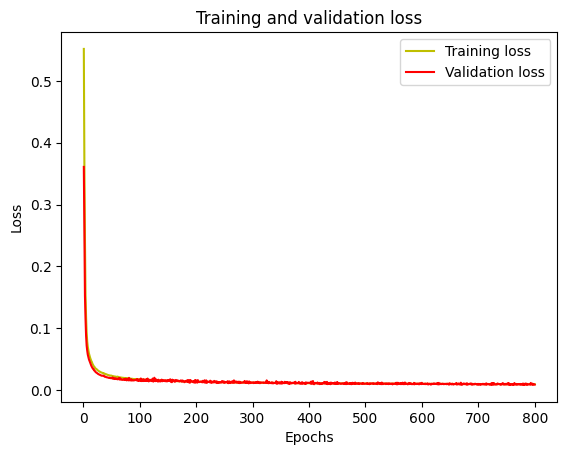

In [209]:
loss = winter_history.history['loss']
val_loss = winter_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [261]:
'''def monsoon_build(X_train, Y_train, save_weights=True, 
                save_best_only=True, min_improvement=0.0005):
    saved_model_weights.clear()
    model = Sequential()
    activity = regularizers.L2(0.00001)
    # Convolutional layers
    model.add(Conv2D(filters=8, kernel_size=(1,15), strides=(1, 1), padding="same", 
                     activation='relu',input_shape=(72,15,1)))
    #model.add(MaxPooling2D(pool_size=(2, 1), padding="same"))
    #input_shape=(72,15,1)
    model.add(Conv2D(filters=8, kernel_size=(3,1), strides=(1, 1), padding="same", 
                     activation='relu', activity_regularizer=activity))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=16, kernel_size=(3,1), strides=(1, 1), padding="same", 
                     activation='relu', activity_regularizer=activity))
    model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding="same", 
                     activation='relu', activity_regularizer=activity))
    model.add(MaxPooling2D(pool_size=( 3,3), padding="same"))
   

    initializer = initializers.GlorotUniform()
    
    # Reshape for LSTM
    conv_output_shape = model.output_shape
    print(f"Conv output shape: {conv_output_shape}")
    model.add(Flatten())
    model.add(Dense(1152, activation=activations.sigmoid, activity_regularizer=activity))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation=activations.relu, activity_regularizer=activity))
    model.add(Reshape((4,64)))
    model.add(LSTM(72,return_sequences=True,activity_regularizer=activity))
    model.add(LSTM(72,return_sequences=False,activity_regularizer=activity))
    #model.add(Dropout(0.2))

    #model.add(Dense(256, activation=activations.leaky_relu, activity_regularizer=activity))
    model.add(Dense((nsteps_out*features_out*24),  activation= activations.linear,activity_regularizer=activity, kernel_initializer=initializer))
    model.add(Reshape((nsteps_out*24, features_out)))
    
    
    # Compile model
    model.compile(loss='mse', 
                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 metrics=['mae','accuracy'])
    
    # Prepare callbacks
    callbacks = []
    if save_weights:
        rmse_callback = RMSECheckpoint(save_best_only=save_best_only, 
                                      min_improvement=min_improvement)
        callbacks.append(rmse_callback)
    
    # Train model
    print(f"🚀 Starting training with RMSE-based weight saving")
    print(f"💾 Weight saving: {'Enabled' if save_weights else 'Disabled'}")
    print(f"🎯 Save strategy: {'Best only' if save_best_only else 'All improvements'}")
    print(f"📊 Min improvement: {min_improvement}")
    print("-" * 60)
    
    history = model.fit(X_train, Y_train, 
                       validation_split=0.10, 
                       epochs=800, 
                       batch_size=128,
                       callbacks=callbacks,
                       verbose=1)
    
    print(f"\n🎉 Training completed!")
    print(f"💾 Total models saved: {len(saved_model_weights)}")
    
    return model, history, saved_model_weights if save_weights else []'''

In [262]:
monsoon_model,monsoon_history, monsoon_model_weights = monsoon_build(monsoon_train_X, monsoon_train_Y)


Conv output shape: (None, 12, 3, 16)
🚀 Starting training with RMSE-based weight saving
💾 Weight saving: Enabled
🎯 Save strategy: Best only
📊 Min improvement: 0.0005
------------------------------------------------------------
Epoch 1/800


E0000 00:00:1750084555.228748      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_14_1/dropout_29_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 2.3220e-04 - loss: 0.7021 - mae: 0.4188
✅ WEIGHTS SAVED!
📊 Epoch: 1
📉 Train RMSE: 0.770279
📉 Val RMSE: 0.652631
📈 Combined RMSE: 0.711455
🎯 Reason: Best combined RMSE: 0.711455
💾 Total saved models: 1
------------------------------------------------------------
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 2.0073e-04 - loss: 0.6605 - mae: 0.3936 - val_accuracy: 0.0000e+00 - val_loss: 0.4259 - val_mae: 0.2163
Epoch 2/800
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.4865e-04 - loss: 0.4541 - mae: 0.2001
✅ WEIGHTS SAVED!
📊 Epoch: 2
📉 Train RMSE: 0.628004
📉 Val RMSE: 0.525744
📈 Combined RMSE: 0.576874
🎯 Reason: Best combined RMSE: 0.576874
💾 Total saved models: 2
------------------------------------------------------------
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.4226e-04 - loss: 0.4323 - mae: 0.1903 - val_accuracy: 0.0000e+00 - val_loss: 0.2764 - val_mae: 0.1214
Epoch 3/800
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc

In [128]:
restore_best_weights(monsoon_model)

monsoon_model.save('monsoon_model_t.keras')

🔄 Restoring best weights (lowest combined_rmse):
📊 Epoch: 50
📉 Train RMSE: 0.175294
📉 Val RMSE: 0.161085
📈 Combined RMSE: 0.168189
🎯 Reason saved: Best combined RMSE: 0.168189
✅ Weights restored successfully!


In [80]:
winter_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)                   │ (None, 72, 15, 8)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 72, 15, 8)           │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 36, 8, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 36, 8, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 36, 8, 16)           │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 36, 8, 16)           │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 12, 3, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1024)                │         590,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_19 (Reshape)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 4, 72)               │          39,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 72)                  │          41,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 24)                  │           1,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_20 (Reshape)                 │ (None, 24, 1)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,817,794 (10.75 MB)

 Trainable params: 939,264 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,878,530 (7.17 MB)

In [81]:
print(monsoon_model.summary())

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)                   │ (None, 72, 15, 8)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 72, 15, 8)           │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 36, 8, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 36, 8, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 36, 8, 16)           │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 36, 8, 16)           │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 12, 3, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1152)                │         664,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_27 (Reshape)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 4, 72)               │          39,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 72)                  │          41,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 24)                  │           1,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_28 (Reshape)                 │ (None, 24, 1)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,137,666 (11.97 MB)

 Trainable params: 1,045,888 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,091,778 (7.98 MB)

None


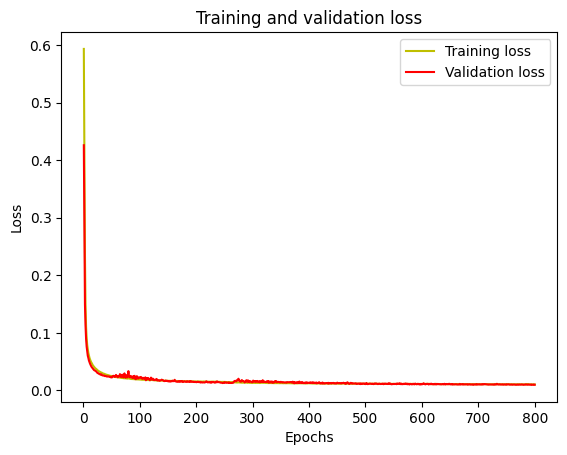

In [265]:
loss = monsoon_history.history['loss']
val_loss = monsoon_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [83]:
import math
def denormalize(df,field,pred_arr):
    actual_field = df[field]
    actual_field = list(actual_field)
  
    mini = min(actual_field)
    maxi = max(actual_field)
    
    divisor = maxi-mini
    arr= np.array(pred_arr)
    col = 0
    if(field == 'pressure'):
        col = 1
    
    new_arr = []
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            new_arr.append(arr[i][j][col])
    for i in range(len(new_arr)):
        new_arr[i] = (new_arr[i]*divisor + mini)
    return new_arr

In [144]:
from tensorflow.keras.models import load_model
summer_model = load_model("/kaggle/working/final_summer.keras")
monsoon_model = load_model("/kaggle/working/final_monsoon.keras")
winter_model = load_model("/kaggle/working/final_winter.keras")



In [84]:
summer_test_prediction = summer_model.predict(summer_test_X)
winter_test_prediction = winter_model.predict(winter_test_X)
monsoon_test_prediction = monsoon_model.predict(monsoon_test_X)

I0000 00:00:1750354257.940903     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


In [85]:
temp_summer_test = denormalize(summer_test,'tempC',summer_test_prediction)

temp_monsoon_test = denormalize(monsoon_test,'tempC',monsoon_test_prediction)

temp_winter_test = denormalize(winter_test,'tempC',winter_test_prediction)


In [86]:
pred_summer_test = {}
pred_summer_test = pd.DataFrame({
    'date_time': date_list_summer_test_Y,
    'tempC': temp_summer_test,
   
})



pred_summer_test['date_time'] = pd.to_datetime(pred_summer_test['date_time'])

pred_monsoon_test = {}

pred_monsoon_test = pd.DataFrame({
    'date_time': date_list_monsoon_test_Y,
    'tempC': temp_monsoon_test,
   
})

pred_monsoon_test['date_time'] = pd.to_datetime(pred_monsoon_test['date_time'])


pred_winter_test = {}

pred_winter_test = pd.DataFrame({
    'date_time': date_list_winter_test_Y,
    'tempC': temp_winter_test,
})

pred_winter_test['date_time'] = pd.to_datetime(pred_winter_test['date_time'])





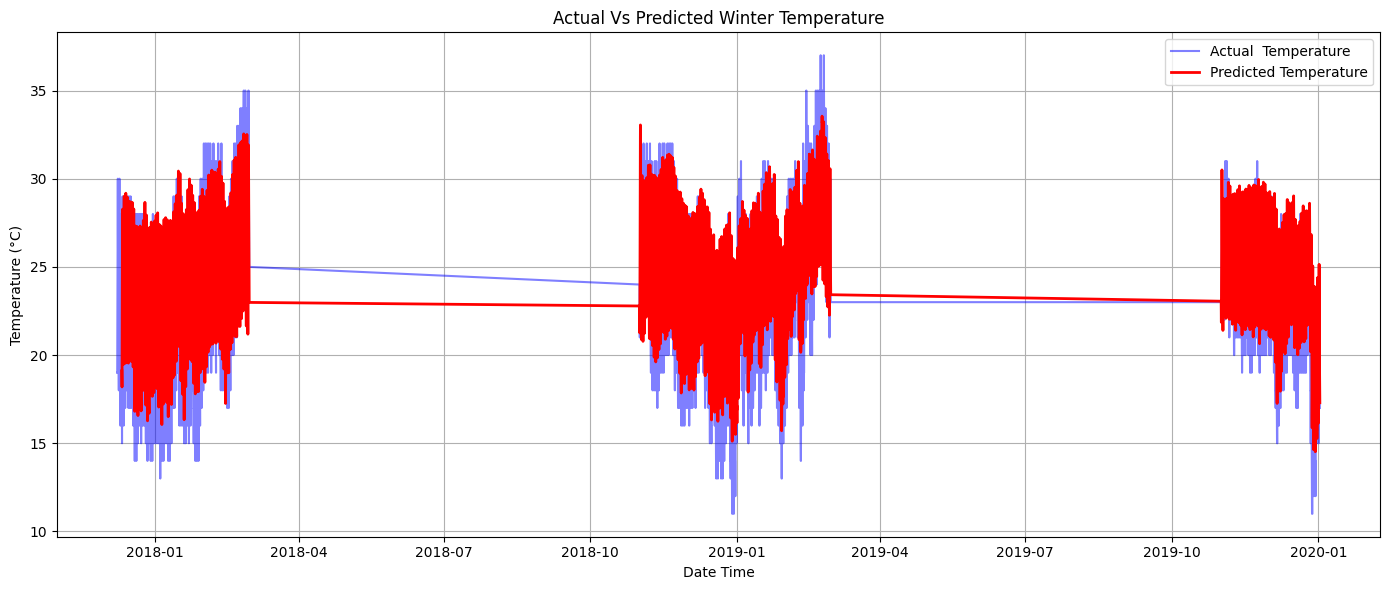

In [87]:
import matplotlib.pyplot as plt

# Plot temperature
plt.figure(figsize=(14, 6))
plt.plot(winter_test.index, winter_test['tempC'], label='Actual  Temperature', color='blue', alpha=0.5)
plt.plot(pred_winter_test['date_time'], pred_winter_test['tempC'], label='Predicted Temperature', color='red', linewidth=2)
plt.title('Actual Vs Predicted Winter Temperature')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot pressure

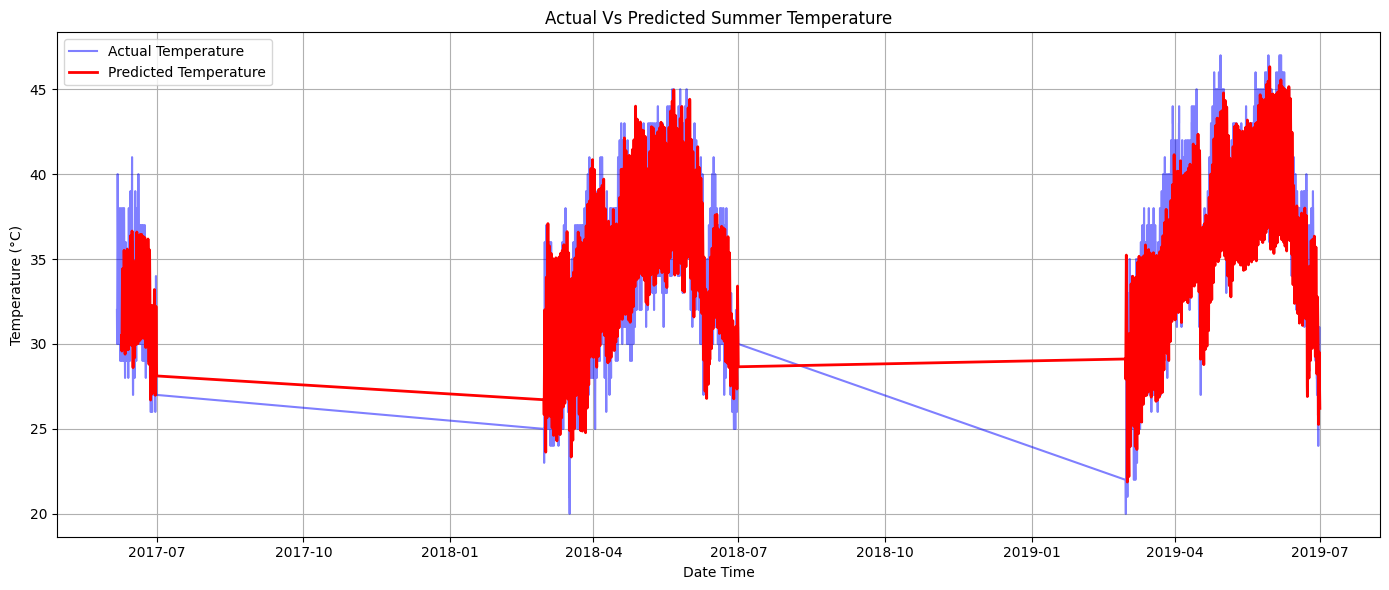

In [88]:
import matplotlib.pyplot as plt

# Plot temperature - Summer
plt.figure(figsize=(14, 6))
plt.plot(summer_test.index, summer_test['tempC'], label='Actual Temperature', color='blue', alpha=0.5)
plt.plot(pred_summer_test['date_time'], pred_summer_test['tempC'], label='Predicted Temperature', color='red', linewidth=2)
plt.title('Actual Vs Predicted Summer Temperature')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot pressure - Summer
#plt.figure(figsize=(14, 6))
#plt.plot(summer_test.index, summer_test['pressure'], label='Summer Pressure', color='green', alpha=0.5)
#plt.plot(pred_summer_test['date_time'], pred_summer_test['pressure'], label='Predicted Pressure', color='orange', linewidth=2)
#plt.title('Summer Pressure Comparison')
#plt.xlabel('Date Time')
#plt.ylabel('Pressure')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()


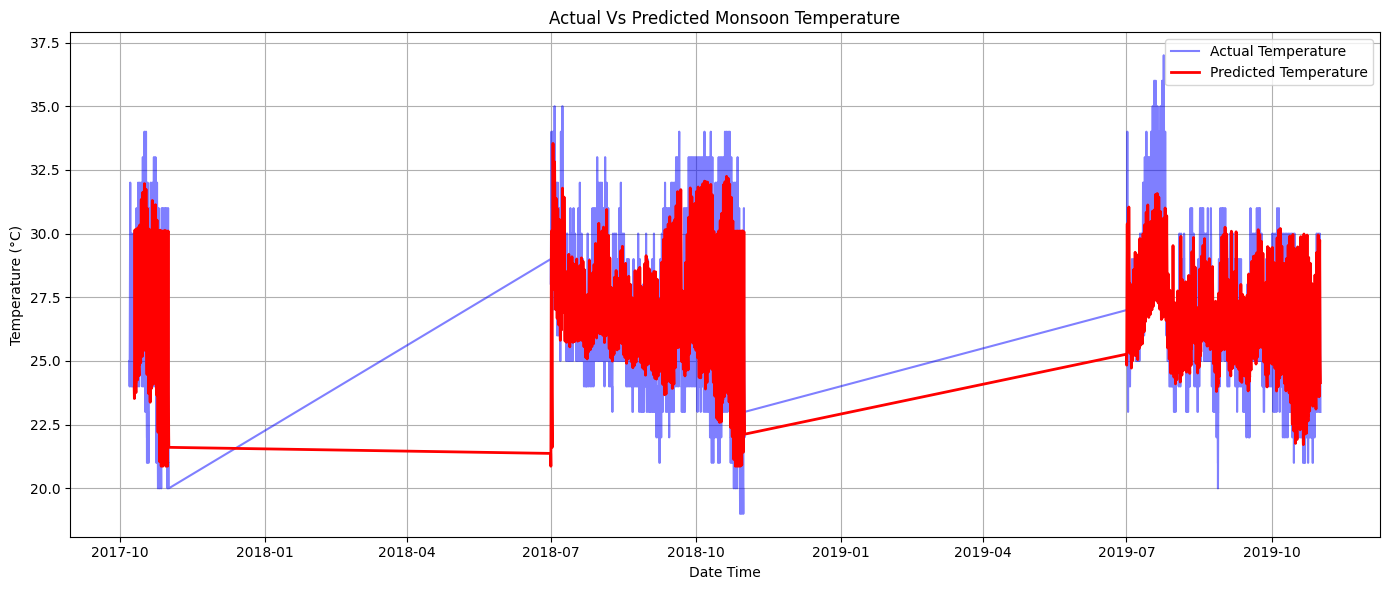

In [89]:
# Plot temperature - Monsoon
plt.figure(figsize=(14, 6))
plt.plot(monsoon_test.index, monsoon_test['tempC'], label='Actual Temperature', color='blue', alpha=0.5)
plt.plot(pred_monsoon_test['date_time'], pred_monsoon_test['tempC'], label='Predicted Temperature', color='red', linewidth=2)
plt.title('Actual Vs Predicted Monsoon Temperature')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
pred_summer_test['date_time'] = pd.to_datetime(pred_summer_test['date_time'])
pred_summer_test.set_index('date_time', inplace=True)

In [91]:
pred_winter_test['date_time'] = pd.to_datetime(pred_winter_test['date_time'])
pred_winter_test.set_index('date_time', inplace=True)

In [92]:
pred_monsoon_test['date_time'] = pd.to_datetime(pred_monsoon_test['date_time'])
pred_monsoon_test.set_index('date_time', inplace=True)

In [93]:
import pandas as pd
import numpy as np

# Align the two DataFrames on index
common_index = pred_summer_test.index.intersection(summer_test.index)

# Get the values for comparison
actual = summer_test.loc[common_index, 'tempC']
predicted = pred_summer_test.loc[common_index, 'tempC']
mse = np.mean((actual - predicted) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual - predicted))


print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 2.2035080673595018
MAE: 1.6991384983994067


In [94]:
# Align the two DataFrames on index
common_index = pred_monsoon_test.index.intersection(monsoon_test.index)

# Get the values for comparison
actual = monsoon_test.loc[common_index, 'tempC']
predicted = pred_monsoon_test.loc[common_index, 'tempC']

mse = np.mean((actual - predicted) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual - predicted))


print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 1.6876295802845815
MAE: 1.285972415133662


In [95]:
# Align the two DataFrames on index
common_index = pred_winter_test.index.intersection(winter_test.index)

# Get the values for comparison
actual = winter_test.loc[common_index, 'tempC']

predicted = pred_winter_test.loc[common_index, 'tempC']
mse = np.mean((actual - predicted) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual - predicted))


print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 2.2499469630887634
MAE: 1.7913934571464705


In [52]:
#summer_model.save("final_summer.keras")
#winter_model.save("final_winter.keras")
#monsoon_model.save("final_monsoon.keras")

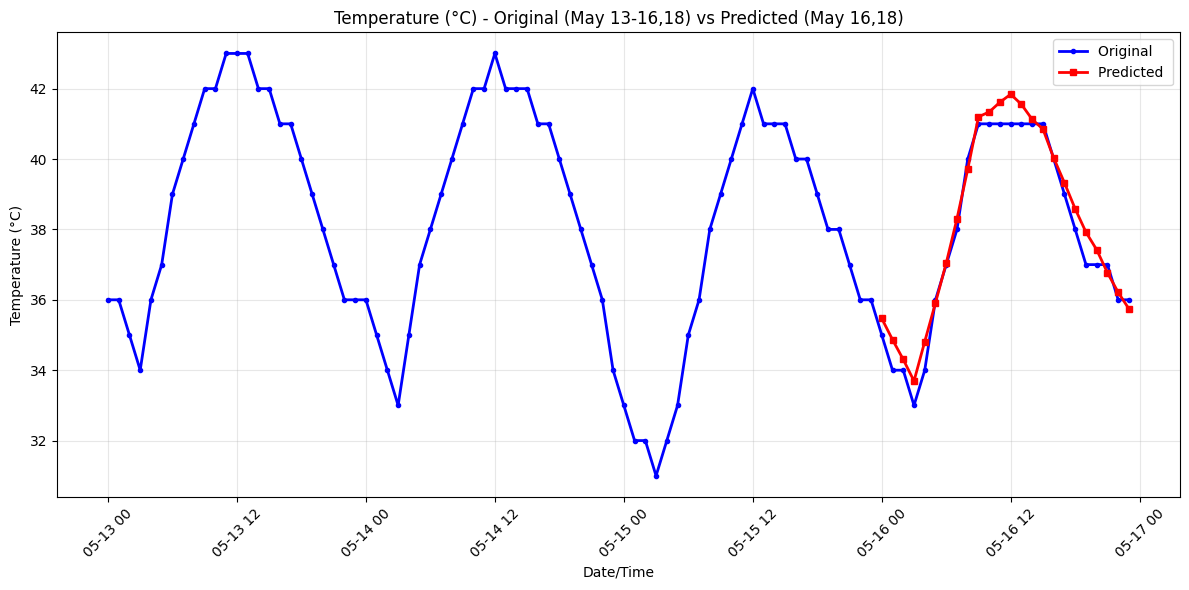

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter original data for the date range (2018-05-13 to 2018-05-16)
original_data = summer_test.loc['2018-05-13':'2018-05-16']
# Filter predicted data for only the specific date (2018-05-16)
pred_data = pred_summer_test.loc['2018-05-16']

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(original_data.index, original_data['tempC'], linewidth=2, marker='o', markersize=3, label='Original ', color='blue')
plt.plot(pred_data.index, pred_data['tempC'], linewidth=2, marker='s', markersize=4, label='Predicted ', color='red')
plt.title('Temperature (°C) - Original (May 13-16,18) vs Predicted (May 16,18)')
plt.xlabel('Date/Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


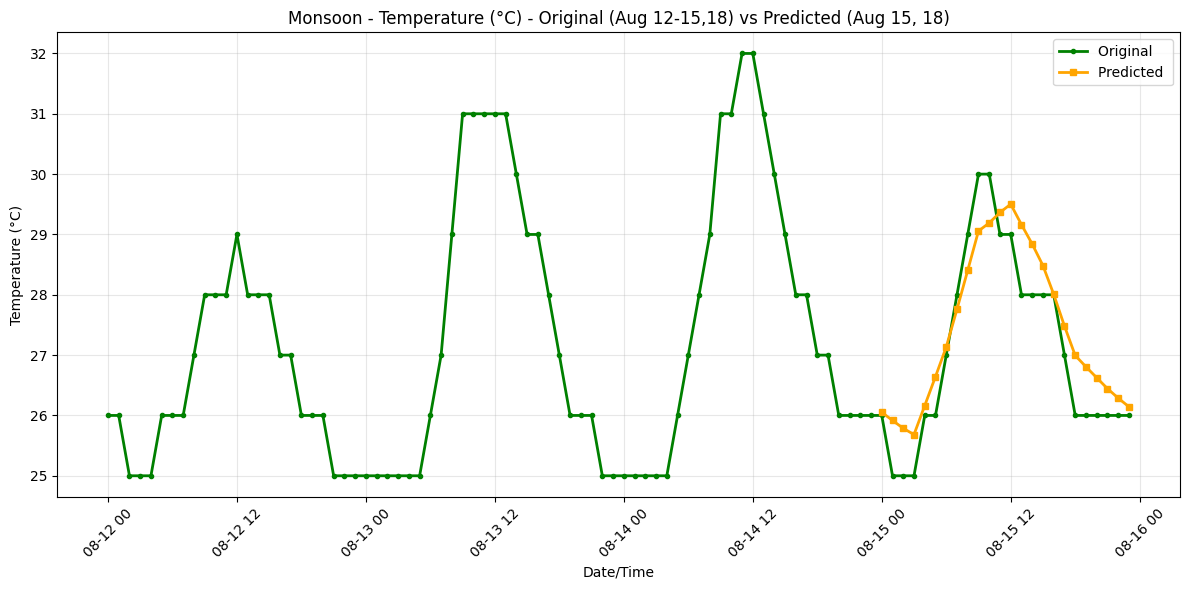

In [97]:
import matplotlib.pyplot as plt
import pandas as pd

# Monsoon plot - replace with your actual dates
# Example: plotting from 2018-07-10 to 2018-07-13 with predictions on 2018-07-13
original_monsoon = monsoon_test.loc['2018-08-12':'2018-08-15']
pred_monsoon = pred_monsoon_test.loc['2018-08-15']

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(original_monsoon.index, original_monsoon['tempC'], linewidth=2, marker='o', markersize=3, label='Original ', color='green')
plt.plot(pred_monsoon.index, pred_monsoon['tempC'], linewidth=2, marker='s', markersize=4, label='Predicted ', color='orange')
plt.title('Monsoon - Temperature (°C) - Original (Aug 12-15,18) vs Predicted (Aug 15, 18)')
plt.xlabel('Date/Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

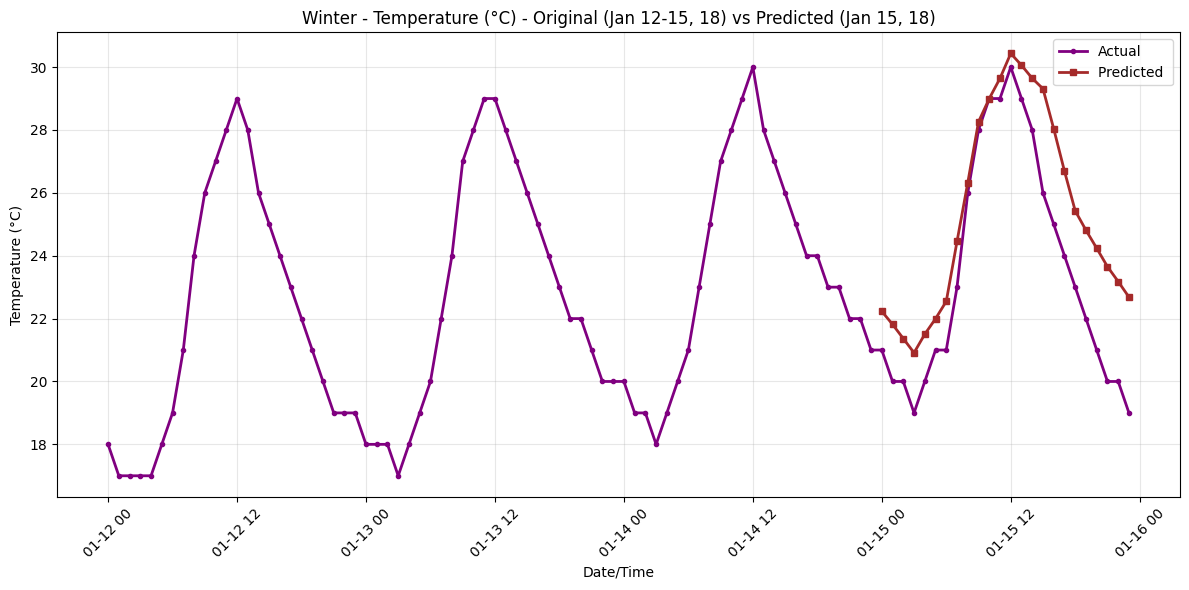

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

# Winter plot - replace with your actual dates
# Example: plotting from 2018-12-20 to 2018-12-23 with predictions on 2018-12-23
original_winter = winter_test.loc['2018-01-12':'2018-01-15']
pred_winter = pred_winter_test.loc['2018-01-15']

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(original_winter.index, original_winter['tempC'], linewidth=2, marker='o', markersize=3, label='Actual', color='purple')
plt.plot(pred_winter.index, pred_winter['tempC'], linewidth=2, marker='s', markersize=4, label='Predicted ', color='brown')
plt.title('Winter - Temperature (°C) - Original (Jan 12-15, 18) vs Predicted (Jan 15, 18)')
plt.xlabel('Date/Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()